<a href="https://colab.research.google.com/github/MLP-deepdreamteam/Image_captioning_deepdreamteam/blob/branch_%EA%B9%80%EC%9C%A4%EC%84%B1/(final)image_captioning_coco30k_mobilenet_augm_attention_explanation6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers import add

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model

In [3]:
from google.colab import auth
auth.authenticate_user()

### 드라이브 마운트 & os확인

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
from zipfile import ZipFile

In [6]:
! gsutil cp gs://coco_custom30k/custom30k.zip /content/coco_custom30k

Copying gs://coco_custom30k/custom30k.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][  4.6 GiB/  4.6 GiB]   22.3 MiB/s                                   
Operation completed over 1 objects/4.6 GiB.                                      


In [7]:
with ZipFile("/content/coco_custom30k") as zfile:
  zfile.extractall(".")

In [8]:
import os
sample_path ="/content/content/custom_train_coco_30k"
sample_train = os.listdir(sample_path)

## 

In [9]:
print(len(sample_train), sample_train[:3])

30000 ['000000465556.jpg', '000000467875.jpg', '000000439628.jpg']


# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json

In [10]:
import pandas as pd
import json

with open(f'/content/drive/MyDrive/coco_dataset/coco_ann2017/annotations/captions_train2017.json', 'r') as f: # 마운트 확인

    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption'],sample['image_id']])

captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption','image_id'])
captions['image'] = captions['image'].apply(
    lambda x: f'/content/drive/MyDrive/coco_dataset//train2017/{x}'
)
captions = captions.reset_index(drop=True)
print(captions.head(3))

                                               image  \
0  /content/drive/MyDrive/coco_dataset//train2017...   
1  /content/drive/MyDrive/coco_dataset//train2017...   
2  /content/drive/MyDrive/coco_dataset//train2017...   

                                             caption  image_id  
0  A bicycle replica with a clock as the front wh...    203564  
1  A room with blue walls and a white sink and door.    322141  
2  A car that seems to be parked illegally behind...     16977  


In [11]:
df_captions_in_COCO = captions.groupby(["image", "image_id"])['caption'].apply(list).reset_index()

df_captions_in_COCO.shape

(118287, 3)

In [12]:
# 캡션 내역 확인
# df_captions_in_COCO.head()
print(df_captions_in_COCO.shape)

print(
df_captions_in_COCO.head(),
"\n",
df_captions_in_COCO.iloc[0,0],
"\n",
df_captions_in_COCO.iloc[0,1],
"\n",
df_captions_in_COCO.iloc[0,2])

(118287, 3)
                                               image  image_id  \
0  /content/drive/MyDrive/coco_dataset//train2017...         9   
1  /content/drive/MyDrive/coco_dataset//train2017...        25   
2  /content/drive/MyDrive/coco_dataset//train2017...        30   
3  /content/drive/MyDrive/coco_dataset//train2017...        34   
4  /content/drive/MyDrive/coco_dataset//train2017...        36   

                                             caption  
0  [Closeup of bins of food that include broccoli...  
1  [A giraffe eating food from the top of the tre...  
2  [A flower vase is sitting on a porch stand., W...  
3  [A zebra grazing on lush green grass in a fiel...  
4  [Woman in swim suit holding parasol on sunny d...   
 /content/drive/MyDrive/coco_dataset//train2017/000000000009.jpg 
 9 
 ['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful

In [13]:
# df to dict

### {for 문 } = dictionary comprehension 으로 dictionary 생성, df_captions_in_COCO에 들어있는 이미지 경로 df_captions_in_COCO['images'] 는  /content/drive/MyDrive/coco_dataset//train2017/000000000009.jpg  처럼 // 가 들어가있어서 다시 세팅하는코드

### 아래 알고리즘은 더 좋은 방식이 있으나 당시 좋은방법이 생각안나서 이렇게 하였습니다. 
## 위에 (mypath_dict 는  경로 : 캡션) 인 dictionary, (myid_dict 는 id : 캡션)인 dictionary 만들어보기 

### 애초부터 이 두개 만든 이유는 db 처럼 id를 통해 view/join 이 되면 좋으나 당시에 db 가 없어서 이렇게 하였습니다. DB 가 있으면 필요없습니다.

mypath_dict = {row['image']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}


# Or, use the 'image_id' column as the key
myid_dict = {row['image_id']: row['caption'] for _, row in df_captions_in_COCO.iterrows()}

In [14]:
print(len(mypath_dict), len(myid_dict))
print(myid_dict[9])

##  그렇다면 id : caption이니 작동삼아 key 가 9 라면 해당 caption 불러오는지 확인

118287 118287
['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


In [15]:
# 현재 sapmle_train 이라는 파일에는 




my_sample_path = []
my_image_id= []

for jpg_file in sample_train:
    # print(jpg_file)   000000295074.jpg 의꼴
    my_sample_path.append(sample_path+"/" +jpg_file)
    # 실제 우리 파일경로 sample_path # print(sample_path) /content/content/custom_train_coco_30k 에 append 시켜서 새로운  이미지 경로 리스트 생성


    # exctract id in sample 아이디만 뽑아오기. 위의 jpg_file 에서 앞부분 숫자만 가져오기
    image_id = int(jpg_file.split('.')[0])
    my_image_id.append(image_id)

print(my_sample_path[:2],"\n", len(my_sample_path)) # 내가 만든 파일경로에 잘들어갓는지 확인용
print()
print(my_image_id[:3], len(my_image_id)) # 내가만든 파일의 아이디 번호가 잘 들어갔는지 확인


#요약 

# 우리가 가진 3만개( 샘플 트레인) 데이터셋을 호출하고 그걸 이미지경로/ 키로 분리한 리스트 생성

['/content/content/custom_train_coco_30k/000000465556.jpg', '/content/content/custom_train_coco_30k/000000467875.jpg'] 
 30000

[465556, 467875, 439628] 30000


In [16]:
# Function to check if the image ID is in the my_image_id list
def keep_id(image_id):
    return image_id in my_image_id 
    # my_image_id 는 3만개 id , 즉 image_id 가 3 만개중에 있으면 True 호출

# Create a custom dictionary with only the partial image IDs
my_custom_train_set = {k: v for k, v in myid_dict.items() if keep_id(k)}
print(len(my_custom_train_set))



## 현재 myid_dict.items는 11만개 코코데이터셋,  if절 만족 한다면 3만개만 호출하게 되는 로직, 그렇다면 그 3만개에 대해서
# my_custom_train_set 이라는 3만개 에 id_key / caption dictionary 생성

30000


captions (json 으로 만든), id는 11만개,
폴더에 실제로 지금 가져온 id는 3만개,
위 코드를 통해서 아이디를 위에 caption 
즉 내 폴더에있는 아이디만 가지고 dict 를 만듬

In [17]:

# 하지만 위에 생성된  dictionary 는 id_key : caption 이기 때문에, 실제 경로로 만들어주는 코드 작성, id _key 는 정수형이기떄문에 0000009 가 아닌 9로만 저장됨.

updated_dict = {}
for k, v in my_custom_train_set.items():
    
    new_key = sample_path+"/{:012d}.jpg".format(k)
    updated_dict[new_key] = v


# 이렇게만든다면 id_keys : caption -> 이미지파일경로 + id_key () 12자리]  : caption으로 바꾸는작업


In [18]:
len(updated_dict)

30000

#### Load some of the random images

In [19]:
# 샘플 확인용 # 실제 upadated_dcit 가 내가 원하는꼴인지 확인용

imgIdss= list(updated_dict.keys())



# upadated_dict 는 

#updated_dict =  {/content/content/custom_train_coco_30k/000000563177.jpg :  caption} 이런꼴임. 즉 {key : value} 꼴이라면 

# dictionary.keys(), .values(), .items() 이렇게 3개 있는데 keys는 dictionary 의 keys만, values는 values 만, items 는 key, item 합친 튜플로 호출

# dictionary 형태는 단순 dict [숫자] 형태로 호출할 수 없음. 그렇기 떄문에 dictionary.keys() 를 list 로 감싸면 list 형태로 호출 가능.
import random
random.shuffle(imgIdss)

#랜덤셔플해서 9번쨰 key를 불러오기

print(imgIdss[9])


/content/content/custom_train_coco_30k/000000493483.jpg


The clock tower is in front of the mountains.
A giraffe standing in a field next to a small tree.
A giraffe is standing alone in the wild. 
A picture of some animals in the dirt.
A group of passenger loading and unloading from trains.
A couple of metal sinks in a room.
A large dog on a beach in the water.
Freshly shorn sheep eat grass in a mountain pasture
Tan stone tiled and tub cover and bathroom floor with glass shower and white porcelain toilet and tub. 
A tall man is talking to a girl while eating
Several teddy bears are on a table and hanging on a wall.
A street with market door openings is empty.


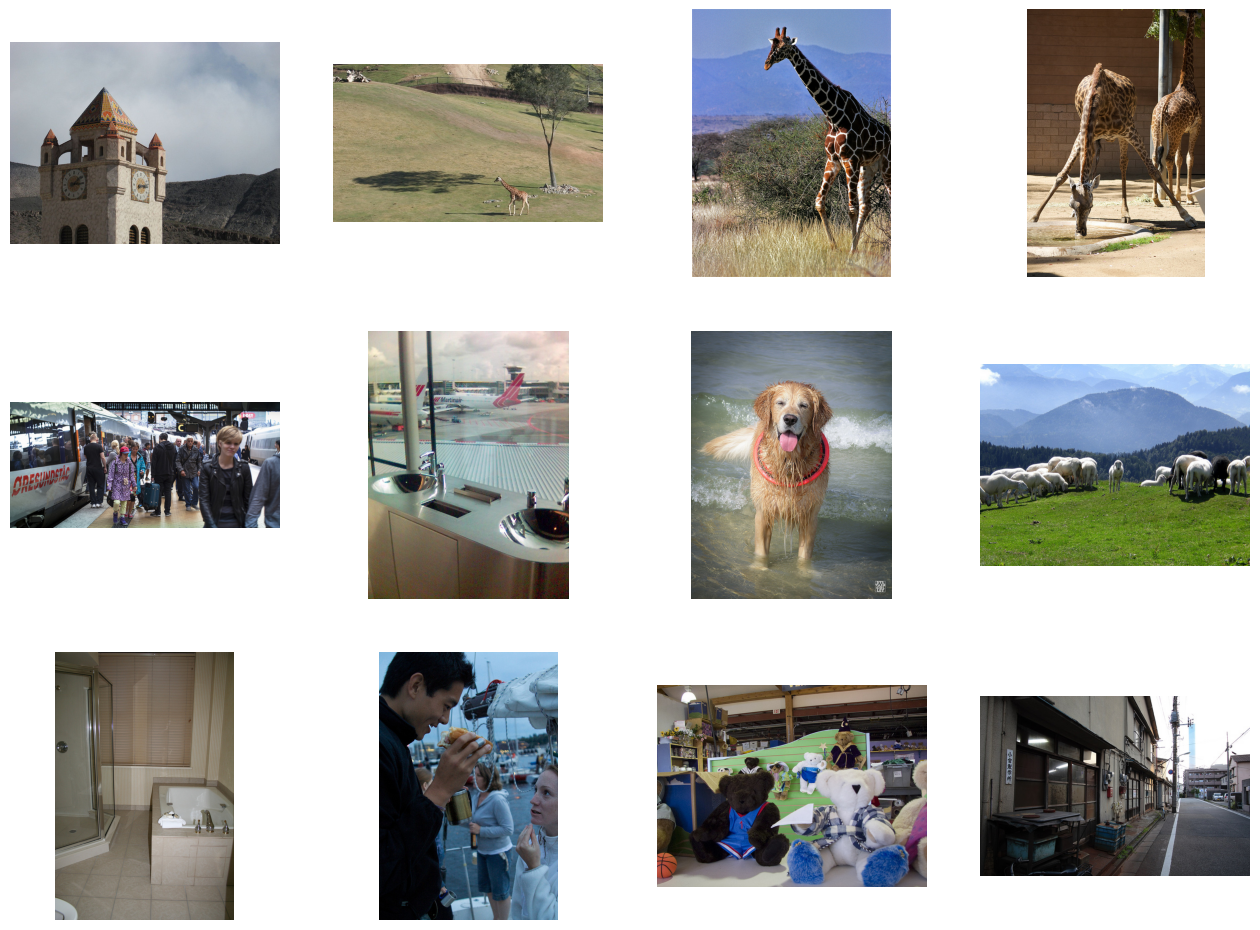

In [20]:
import matplotlib.pyplot as plt
import skimage.io as io

# 랜덤 파일 읽기, imgidss 확인!! -전체코코인지 일부인지
fig = plt.gcf()

# fig 라는 plt 객체 생성
fig.set_size_inches(16, 16)
# fig 객체에 크기설정

next_pix = imgIdss

random.shuffle(next_pix)
# 위에 샘플 은 imgIdss 라는 랜덤 key를 가지고  next_pix 랜덤섞어줌 위에 이미 랜덤이 있어서 호출할필요는없음 (랜덤 두번한셈)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    # plt객체에 subplot 속성추가 (크기, 숫자등)
    sp.axis('Off') # 축 표시 제거
    I = io.imread(img_path) # io.imread() 는 imread 를통해 파일경로를 주면 I 라는 plt 가 읽을 수 있는 이미지 파일을 읽어옴.
    
    plt.imshow(I)
    # I 가 경로가아닌 실제 이미지 파일이면 그걸 imshow를 통해서 보여줌
    print( updated_dict[img_path][0])
    # 우리가 가진 updated_dict에 img 파일 에 caption을 불러옴. 단 caption이 5개니 첫번쨰 caption만 호출

plt.show()


# plt show 메소드

In [21]:
import pickle
import tensorflow as tf
from tensorflow.io.gfile import GFile
from tensorflow.keras.preprocessing.text import Tokenizer


In [22]:
with open("/content/drive/MyDrive/3조/test2_pickle", "rb") as f:     # pickle 불러올떄 open( 경로 , "rb") as f , rb는 read binary, 작성할떈 wb (write binaray). with 문을쓰면 뒤에 as f 를 해서 with 코드작성
    df = pickle.load(f)

#피클을 불러옴 , 이미 황인님이랑 같이한 코드에서 DataFrame객체로 28846 개로 줄인 df 를 불러옴
#

display( df.head(1))
print(len(df))

id_key                                        Img_address  \
0  000000000025  /content/content/custom_train_coco_30k/0000000...   

                                         caption_1  \
0  A giraffe eating food from the top of the tree.   

                              caption_2  \
0  A giraffe standing up nearby a tree    

                                       caption_3  \
0  A giraffe mother with its baby in the forest.   

                                      caption_4  \
0  Two giraffes standing in a tree filled area.   

                                           caption_5  \
0  A giraffe standing next to a forest filled wit...   

                                        caption_list  
0  A giraffe eating food from the top of the tree...

28846


In [23]:
print(df.columns)
updated_dict={}

for i in range(len(df)):
  img_address = df.iloc[i]['Img_address']
  caption_list = [df.iloc[i]['caption_1'],df.iloc[i]['caption_2'],df.iloc[i]['caption_3'],df.iloc[i]['caption_4'],df.iloc[i]['caption_5']]

  updated_dict[img_address] =caption_list



# 아까 가지고있던파일이 df 였기때문에 우리가 작업하던 dictionary 꼴로 맞추는 코드. 

Index(['id_key', 'Img_address', 'caption_1', 'caption_2', 'caption_3',
       'caption_4', 'caption_5', 'caption_list'],
      dtype='object')


In [24]:
dataset =updated_dict

print(len(dataset))
print(list(dataset.items())[0])

# dataset 에 <start>, <end> 넣기, LSTM 용, 이전에 가지고있던 <start> <end> 가 없었기때문에 추가

newdataset = {k: ['<start> '   +cap+ ' <end>' for cap in caps] for k,caps in dataset.items()}

print(len(newdataset))
print(list(newdataset.items())[0])
print(len(list(newdataset.values())[0]))

dataset =newdataset



# 이젠 dataset 이라는 dictionary는   {colab에 있는 이미지경로 : 리스트(caption)} 꼴.

28846
('/content/content/custom_train_coco_30k/000000000025.jpg', ['A giraffe eating food from the top of the tree.', 'A giraffe standing up nearby a tree ', 'A giraffe mother with its baby in the forest.', 'Two giraffes standing in a tree filled area.', 'A giraffe standing next to a forest filled with trees.'])
28846
('/content/content/custom_train_coco_30k/000000000025.jpg', ['<start> A giraffe eating food from the top of the tree. <end>', '<start> A giraffe standing up nearby a tree  <end>', '<start> A giraffe mother with its baby in the forest. <end>', '<start> Two giraffes standing in a tree filled area. <end>', '<start> A giraffe standing next to a forest filled with trees. <end>'])
5


Preprocess and tokenize the captions

In [25]:
#  train/val 대상 확인
import itertools

keys = list(dataset.keys())

random.seed(42)
random.shuffle(keys)
# 임시 : sample은 개수## train_ratio
train_size= int(len(dataset)*0.75)

val_size = len(dataset)-train_size
print(train_size, val_size)


train_keys =keys [:train_size]
val_keys = keys[train_size:]

data_train = {k : dataset[k] for k in train_keys}
data_val = {k : dataset[k] for k in val_keys}


# 이젠 data_train 이라는 dictionary는   {colab에 있는 이미지경로 : 리스트( <start> caption. <end>)} 꼴., 21634 (28846*0.75)
# 이젠 data_val 이라는 dictionary는   {colab에 있는 이미지경로 : 리스트( <start> caption. <end>)} 꼴. 7212개 (28846 - 28846*0.25) 개


21634 7212


In [26]:
list(data_train.items())[:2] #확인용

[('/content/content/custom_train_coco_30k/000000106499.jpg',
  ['<start> Man and woman looking at large suitcase on sidewalk. <end>',
   '<start> a man and a woman stand outside while she holds a luggage <end>',
   '<start> A man and a woman looking at a suitcase. <end>',
   '<start> A woman standing next to a man in blue shirt and pants. <end>',
   '<start> A man and a woman looked down at a suitcase.  <end>']),
 ('/content/content/custom_train_coco_30k/000000450127.jpg',
  ['<start> A living room with a blue couch with a red area rug and a fire place in the corner.  <end>',
   '<start> A gray couch sitting on top of a rug in a living room. <end>',
   '<start> A very nice looking living room with a fire place. <end>',
   '<start> this living room has a couch and a fire place <end>',
   '<start> This living room has a fancy rug, a couch, and a wood burning stove. <end>'])]

In [27]:

from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize_mycaption(dataset, max_words=15000): 
  
  flatten_list = list(chain.from_iterable(dataset.values())) 

  tokenizer = Tokenizer( oov_token='<oov>',num_words =max_words) 
  tokenizer.fit_on_texts(flatten_list) # tokenizer 을 이제 우리 caption 리스트를 fit 해서 저장
  total_vocab_words = len(tokenizer.word_index)  
  print("Vocabulary length: ", total_vocab_words) # tokenizer에 객체가 학습한 단어수 
  print(list(tokenizer.word_index.keys())[:10]) #시험삼아 가장 빈도수 많은 단어 10개 호출
  return tokenizer, total_vocab_words # 함수가 2개로 return

tokenizer, total_vocab_words = tokenize_mycaption(newdataset, max_words=9000) 

Vocabulary length:  15215
['<oov>', 'a', 'end', 'start', 'on', 'of', 'the', 'in', 'with', 'and']


In [28]:
total_words = 9000# 혹시모르니 이후코드에 max_words가 아니라 total_words 로 9000다시 쓰임

In [29]:
# 해당 3만개 데이터에 대한 tokenizer 저장  (15691 단어 수)
import pickle

with open(f"my_tokenizer.pkl", "wb") as f:
    pickle.dump({"tokenizer": tokenizer}, f)

#토크나이저 저장용

In [30]:
with open(f"my_tokenizer.pkl", "rb") as f:
  token_dic = pickle.load(f)
print(token_dic.items())
print(token_dic['tokenizer'])

#토크나이저 잘 불러오는지 확인

dict_items([('tokenizer', <keras.preprocessing.text.Tokenizer object at 0x7f708b41ead0>)])


In [31]:
dataset_list = list(dataset)

sample_link = dataset_list[0]

sample_captions = dataset[sample_link]

sample_link, sample_captions


# 다시 모델학습하기전 그냥 sample 몇개 뽑아봐서 데이터가 잘들어있는지 확인용

('/content/content/custom_train_coco_30k/000000000025.jpg',
 ['<start> A giraffe eating food from the top of the tree. <end>',
  '<start> A giraffe standing up nearby a tree  <end>',
  '<start> A giraffe mother with its baby in the forest. <end>',
  '<start> Two giraffes standing in a tree filled area. <end>',
  '<start> A giraffe standing next to a forest filled with trees. <end>'])

In [32]:
# Image Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
    width_shift_range=0.1, # changed
    height_shift_range=0.1, # changed
    shear_range=0.1, # changed
    zoom_range=0.1, # changed
    horizontal_flip=True, # changed
    vertical_flip=False,
)


# 데이터 augmentation, 즉 CNN 을통해 feature을 저장할때, 

# 이미지 자체를 "노이즈" 형태로 추가하는 작업
#  좌우 반전, 높이 를 바꾸거나 ,확대하거나 등등 해서 이미지를 변경하는 작업

In [33]:
# Encoder 인 Xception 모델 호출, 
# image_feature, imsize, error_imgs 선언, 
# img_preprocess (이미지 사이즈 model 에 맞게 + resize, + 정규화 + feature 추출)

from tensorflow.keras.applications.xception import Xception

from tqdm.notebook import tqdm
import cv2
import numpy as np

model = Xception(include_top=False, pooling='avg',  weights='imagenet')#

image_features = {}

imsize = (299,299)
error_imgs = []

def img_preprocess(dataset=dataset,imsize=imsize, model=model, aug =True  ):
    for img in tqdm(list(dataset.keys())):
        try:
            image = io.imread(img)
            if image.ndim != 3: 
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 

            # Resize each image size 299 x 299 or 224 X 224 
            image = cv2.resize(image, (imsize[1], imsize[0]))
            image = np.expand_dims(image, axis=0)
            if aug == True:
              augmented_image = data_gen.flow(image, batch_size=1).next()
              image = augmented_image

            image = image / 127.5
            image = image - 1.0

            # Extract features from image
            feature = model.predict(image)
            
            [img] = feature

        except:
            print(f"Failed to process image {img}")
            error_imgs.append[img]
            # 에러 코드

# 여기서 

# img_preprocess () 을 실행시킨다면 현재 dataset에 들어가있는 파일경로에 읽히는 이미지를 imagefeature 뱉는 작업을 함.

83683744/83683744 [==============================] - 5s 0us/step


In [34]:
# MobileNet Feature extraction 용
from tensorflow.keras.layers import GlobalAveragePooling2D

IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

x = mobilenet.output
x = GlobalAveragePooling2D()(x)

modified_mobilenetv3small = Model(inputs=mobilenet.input, outputs=x)

# 위와 같은 로직 허나 mobilenet이 뱉는건 (1,576) 꼴이아닌 다른 shape 을 뱉음
print(mobilenet.output.shape) 
# (None, 7,7,576) -> (None,576) 형태로 떨어지게 코드 변형

# 지금보니 mobilenet 만 말썽인 이유는 이때문인듯 ? (None, 7,7,576) -> (None,576) 형태로 떨어지니 기존에 있던 데이터가 날라가는듯 아래는 수정하는코드 심심삼아 작성
from tensorflow.keras.layers import Flatten
new_output = Flatten()(mobilenet.output)

print(new_output.shape)
# 보다싶이 28224라서 너무 큼.
#그렇다면 MaxPool2D 를 해야하는듯. 지금 GlobalAveragePooling은 MaxPool(pool_size= (5,5)) 와 동일한데 pool_size 가 4,5 이상이면 feature관련 손실이 온다고 함., poolsize 변경후 하면 mobilenet 도 살릴 수 는 있을듯합니다.


4334752/4334752 [==============================] - 1s 0us/step
(None, 7, 7, 576)
(None, 28224)


In [35]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

In [36]:
IMAGE_SHAPE=(224, 224, 3)

vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
) 
vgg16.trainable=False

x = vgg16.output
x = GlobalAveragePooling2D()(x)

modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

#vgg 도 mobilent 처럼 같은논리.
print(vgg16.output.shape) 

58889256/58889256 [==============================] - 4s 0us/step
(None, None, None, 512)


In [37]:
import pickle

extract =False 
# 모델바꾸기 , # modelchange
# 230501
#model_e = 'xception_t'
# model_e = 'vgg_t' 
model_e = 'mobilenet_t' 

if extract == True:
  pass
else:
  if model_e=='vgg_t':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_VGG16_30K/vgg16_feature_30000_aug_True.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
  elif model_e=='vgg_f':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_VGG16_30K/vgg16_feature_30000_aug_False.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
  elif model_e=='xception_t':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_Xception_30K/my_feature_30000_yes_aug.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
  elif model_e=='xception_f':
    print("loading :",model_e)
    with open("/content/drive/MyDrive/3조/features_Xception_30K/my_feature_30000_no_aug.pkl", "rb") as f:    
      load_feature_file = pickle.load(f)
  elif model_e=='mobilenet_t':
      print("loading :",model_e)
      with open("/content/drive/MyDrive/3조/features_Mobilenet_30K/my_feature_30000_mb_yes_aug.pkl", "rb") as f:    
        load_feature_file = pickle.load(f)
  elif model_e=='mobilenet_f':
        print("loading :",model_e)
        with open("/content/drive/MyDrive/3조/features_Mobilenet_30K/my_feature_30000_mb_no_aug.pkl", "rb") as f:    
          load_feature_file = pickle.load(f)
  else:
    raise 
  
#예전에  피클로 저장하였던 image feature들이 조금 지저분한 dictionary 형태여서 꺼낼때 코드가 깁니다.


  load_features = list(load_feature_file.values())[0] 

  print(len(load_features))

  keys = list(load_features.keys())
  values =list(load_features.values())

  load_feature_dict  = {}
  print(load_feature_dict)
  my_filepath_key =[sample_path+"/"+ key[-16:] for key in keys]
  print("my_filepath_key:", my_filepath_key[0])
  for i in range(len(keys)):
      load_feature_dict[my_filepath_key[i]] = values[i]

  print("load_feature_dict:",len(load_feature_dict))


# 요약 load_image_dict 라는 {코랩에 있는 이미지파일경로 : feature 벡터 (1,2048)} 형태로 저장

# 확인용

  first_item_key = list(load_feature_dict.keys())[0]
  first_item_value = list(load_feature_dict.values())[0]

  print(first_item_value.shape) # 지금 불러온 feature의 shape
  print( keys[0]) # 지금 이미지 이미지경로키 첫번째것



loading : mobilenet_t
30000
{}
my_filepath_key: /content/content/custom_train_coco_30k/000000000025.jpg
load_feature_dict: 30000
(1, 576)
/content/content/custom_train_coco_30k/000000000025.jpg


In [38]:
len(load_feature_dict)

30000

000000000025.jpg
['/content/content/custom_train_coco_30k/000000000025.jpg', '/content/content/custom_train_coco_30k/000000000081.jpg', '/content/content/custom_train_coco_30k/000000000089.jpg', '/content/content/custom_train_coco_30k/000000000092.jpg', '/content/content/custom_train_coco_30k/000000000151.jpg']
55


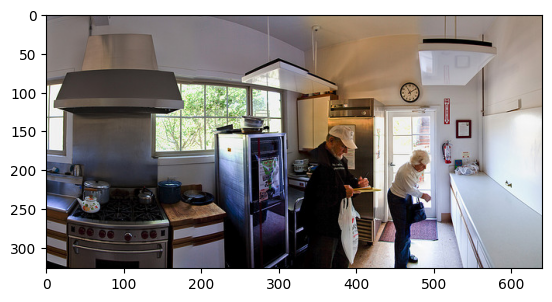

['<start> Two people standing in a kitchen looking around.  <end>',
 '<start> A couple of men are standing in a kitchen <end>',
 '<start> Two people looking at a large kitchen  <end>',
 '<start> An elderly man and woman looking around in a kitchen. <end>',
 '<start> Two people standing close to each other while standing in a kitchen. <end>']

In [39]:
# 이미지 읽어보기 [0]
print(first_item_key[-16:])
print(my_filepath_key[:5])
print(len(my_filepath_key[0]))

# index [0:9999]
im = io.imread(my_filepath_key[12])

plt.imshow(im)
plt.show()

dataset[my_filepath_key[12]]

In [40]:
if load_feature_dict:
  image_features = load_feature_dict

print("Image features length: ", len(image_features))
#위에 로직대로 이미지 피쳐를 가져왔으니 미리짠코드변경하지말고, image_features 라는 이해하기 쉬운 변수로 일단 저장.


Image features length:  30000


In [41]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]] # 이중 for 문 대신 [for] 형태의 list comprenhension 사용 각 리스트문장에 있는 단어에 all_desc 라는 단어가 들어간 문장 1개 를 생성함.
    return all_desc

def max_length_f(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length_f(dataset)
print(max_length)
max_length_v = max_length_f(data_val)
print(max_length_v)
max_length_t = max_length_f(data_train)
print(max_length_t)
max_length


# dict to list , 우리 dataset 형태의 파일의 caption 문장의 단어를 리스트화. 

# max_length_f  그 리스트의 최대값 호출 . 즉 문장길이의 최대값 구하기.
# 구하는 이유는 우리의 모델의 input shape 을 구하기 위하여. input shape이 최대길이만큼만 만들기 위함.

26
26
25


26

Make a Data Generator

In [42]:
#create input-output sequence pairs from the image description.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
current_state = 0

def data_generator(descriptions, features, tokenizer, max_length):
    global current_state

    while 1: 
        for key, description_list in descriptions.items(): # description은 dataset 이라고 생각하시면 편합니다. 
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            current_state +=1
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    num=0
    # walk through each description for the image
    for desc in desc_list: # desc_list 는 caption의 list를 뜻함
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i] 
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0] 
            # print(in_seq.shape)
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words+1)[0] 

            num+=1
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output

    return np.array(X1), np.array(X2), np.array(y)

In [43]:
gen = data_generator(data_val, image_features, tokenizer, max_length)
model_e[:-2]

for i,_ in enumerate(gen):
  print(i)

  if i ==0 :
    break




0


In [44]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention

# define the captioning model
def define_model(total_words, max_length, model= model_e[:-2]):

    # 230501
    print('model: ', model)

    if model == "xception":
        inputs1 = Input(shape=(2048,)) #for Xception 
    elif model == "vgg":
        inputs1 = Input(shape=(512,))# for VGG 
    elif model == "mobilenet":
        inputs1 = Input(shape=(576,)) #for mobilenet 
    
    fe1 = Dropout(0.5)(inputs1) # input 을 dropout 
    fe2 = Dense(256, activation='relu')(fe1) # 256 dense layer

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,)) # 
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax',name = "output")(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam') # metrics = ['acc']

    # summarize model
    print(model.summary())

    return model

  # 모델 정의하기

In [45]:

# from tensorflow.keras.utils import plot_model

# plot_model(test_model, to_file = "model.png", show_shapes=True)



In [46]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
        
    def get_config(self):
        config = super(BahdanauAttention, self).get_config()
        config.update({
            'W1': self.W1,
            'W2': self.W2,
            'V': self.V,
        })
        return config

embedding_dim = 256
units = 256
vocab_size = total_words + 1  # Add 1 for zero padding

# 230501
# encoder_input = Input(shape=(2048,)) # xception
# encoder_input = Input(shape=(512,))  # VGG16
encoder_input = Input(shape=(576,))  # mobilenet


l2_lambda = 0.001
fe1 = Dense(embedding_dim, activation='relu', kernel_regularizer=l2(l2_lambda))(encoder_input)        

fe2 = Dropout(0.5)(fe1)

decoder_input = Input(shape=(max_length,))
decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_input)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.2, name='decoder_lstm')
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=[fe2, fe2])

# Add custom attribute 'decoder_units' to the decoder_lstm layer
decoder_lstm.decoder_units = units

attention_layer = BahdanauAttention(units)
context_vector, attention_weights = attention_layer(fe1, state_h)
decoder_concat = Concatenate(axis=-1)([context_vector, state_h])

dense_layer = Dense(units, activation='relu')
dense_output = dense_layer(decoder_concat)
output = Dense(vocab_size, activation='softmax')(dense_output)

test_model = Model([encoder_input, decoder_input], output)


# 모델 자체를 제가 주석달기에는 너무 복잡할것 같습니다.

In [47]:
test_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',)

# 모델을 정의하였다면. 모델을 compilie을 해야함. 왜냐하면 loss 나 optimizier을 지정하기위함
#모델을 compilie 이되고 나서야 fit 이나 train 가능함


In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'loss', patience =32, verbose = 1,min_delta=0.001)

# 콜백함수 추가

In [49]:
from datetime import datetime
current_time = datetime.now()
timestamp = int(current_time.timestamp())

fit_num=0

model_save_name  =f"/content/drive/MyDrive/3조/Models/{model_e}_{timestamp}+FN+{str(fit_num)}_caption_model.h5"

acc_epoch=0
BATCH_SIZE = 64
EPOCHS=60

def train_our_model(data_train= data_train,
                    data_val=data_val,batch =BATCH_SIZE,
                    model =test_model,                    
                    epochs =EPOCHS, acc_epoch= acc_epoch):  
  global fit_num
  model_save_name  =f"/content/drive/MyDrive/3조/Models/{model_e}_{timestamp}+FN+{str(fit_num)}_caption_model.h5"

  index = model_save_name.find("FN") + 3

  fit_num+=1

  steps_per_epoch_train = train_size //BATCH_SIZE
  steps_per_epoch_val = val_size // BATCH_SIZE
  print('Model feature: ', model_e)
  print('Dataset: ', len(dataset))
  print('Descriptions: val=', len(data_val))
  print('Descriptions: train=', len(data_train))
  print('Photos: =', len(image_features))
  print('Token Vocabulary Size:', total_words)
  print('Total vocabulary:', total_vocab_words)
  print('Description Length: ', max_length)

  fit_set = 1
    
  for i in range(fit_set):

    # train, val generator 
      train_generator = data_generator(data_train, image_features,tokenizer, max_length_t)
      val_generator = data_generator(data_val, image_features, tokenizer, max_length_v)
      # fit with generators with callbacks
      test_fit =model.fit(train_generator,  steps_per_epoch= steps_per_epoch_train,
                          validation_data =val_generator, validation_steps= steps_per_epoch_val,
                          callbacks=[early_stopping],epochs=epochs,use_multiprocessing=True,
                              initial_epoch=acc_epoch,
                          )

      model_save_name  =f"/content/drive/MyDrive/3조/Models/{model_e}_{timestamp}+FN+{str(fit_num)}_caption_model.h5"
      model.save(model_save_name)
  return test_fit


  # 우리의 모델은 정해진 
  # X_train ,X_test , y_train, y_val 형태로 학습하는게 아님. 

  # 핏 ( train 생성자, val생성자, ~~~~) 형태의 정보가 필요함 그렇기 때문에 for i in range(fit_set) / iterator 로 호출 ( 제 추측입니다.)


In [50]:
train_loss_list =[]
val_loss_list =[]

# history 저장용 리스트 생성

In [51]:
test_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 576)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          147712      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 256)      2304256     ['input_5[0][0]']                
                                                                                            

In [52]:

test_model.summary()
test_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',)

for i in range(4):
  history_attention= train_our_model(model=test_model,epochs =64,acc_epoch=0)

  train_loss_list.append(history_attention.history['loss'])
  val_loss_list.append(history_attention.history['val_loss'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 576)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          147712      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 256)      2304256     ['input_5[0][0]']                
                                                                                            

In [53]:
# from google.colab import auth
# auth.authenticate_user()

# from google.cloud import storage

# # Create a GCS client
# client = storage.Client()

# # Replace this with a unique bucket name
# bucket_name = "feature_x_1"

# # Get the bucket
# bucket = client.get_bucket(bucket_name)

# print(f"Accessing bucket {bucket.name}.")


# from google.cloud import storage

# model_list=[
# "/content/drive/MyDrive/3조/Models/xception_t_1682629781+FN+1_caption_model.h5",
# "/content/drive/MyDrive/3조/Models/xception_t_1682629781+FN+2_caption_model.h5",
# "/content/drive/MyDrive/3조/Models/xception_t_1682629781+FN+3_caption_model.h5",
# "/content/drive/MyDrive/3조/Models/xception_t_1682629781+FN+4_caption_model.h5"
# ]
 
# for i, model_file in enumerate(model_list):
#   # Replace with your file path and desired destination path
#   source_file_path = model_file # 경로
#   destination_blob_name = model_file

#   #쓰기용
#   # Create a blob object and upload the file
#   blob = storage.Blob(destination_blob_name, bucket)
#   blob.upload_from_filename(source_file_path)

#   print(f"File {source_file_path} uploaded to {destination_blob_name}.")

In [54]:
# train_loss = history_attention.history['loss']
# val_loss = history_attention.history['val_loss']

fit 실행(epochs)

In [55]:
len(train_loss_list)
a = [y for x in train_loss_list for y in x]
b = [y for x in val_loss_list for y in x]

d = list(zip(range(len(a)),a,b))
print(d)

[(0, 5.665958404541016, 5.037195205688477), (1, 4.772964000701904, 4.6624674797058105), (2, 4.573160648345947, 4.495997428894043), (3, 4.356752395629883, 4.393710136413574), (4, 4.276462554931641, 4.308551788330078), (5, 4.25113582611084, 4.251395225524902), (6, 4.249214172363281, 4.201780319213867), (7, 4.074065208435059, 4.167611598968506), (8, 4.111057758331299, 4.126149654388428), (9, 4.097663402557373, 4.101200580596924), (10, 4.028698921203613, 4.06939172744751), (11, 3.997328758239746, 4.0219597816467285), (12, 3.9741485118865967, 4.012421607971191), (13, 3.92350172996521, 3.9705393314361572), (14, 3.9470021724700928, 3.950831174850464), (15, 3.9708499908447266, 3.9097352027893066), (16, 3.8295130729675293, 3.9143245220184326), (17, 3.837423086166382, 3.8831417560577393), (18, 3.7952775955200195, 3.8682548999786377), (19, 3.8039157390594482, 3.84218692779541), (20, 3.784210443496704, 3.8252055644989014), (21, 3.808486223220825, 3.806349992752075), (22, 3.816884994506836, 3.79000

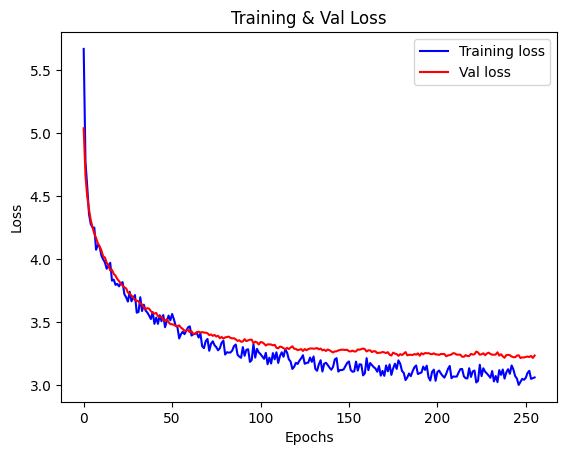

In [56]:
import matplotlib.pyplot as plt

train_loss = history_attention.history['loss']
val_loss = history_attention.history['val_loss']

# Get the number of epochs
# 윤성(230425/train_loss->train_loss_list)
# epochs = range(1, len(train_loss) + 1)
epochs = range(1, len(train_loss_list) + 1)

# Plot the training loss
# 윤성 for관련 변수로 변경 (23042009)
plt.plot(range(len(a)), a, 'b', label='Training loss')
plt.plot(range(len(a)), b, 'r', label='Val loss')

# plt.plot(epochs, train_loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Val loss')

plt.title('Training & Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [57]:
from tensorflow.keras.models import load_model

custom_objects = {
    'BahdanauAttention': BahdanauAttention,
}

In [58]:

for i,model_path in enumerate (os.listdir("/content/drive/MyDrive/3조/Models/")) :
  if f"FN" in model_path and model_e[:-2] in model_path:  
    print(model_path)  


mobilenet_t_1681366497+FN+0_caption_model.h5
mobilenet_t_1681371160+FN+0_caption_model.h5
mobilenet_t_1681439262+FN+0_caption_model.h5
mobilenet_t_1681448579+FN+0_caption_model.h5
mobilenet_f_1681461434+FN+0_caption_model.h5
mobilenet_t_1681691149+FN+0_caption_model.h5
mobilenet_t_1681695187+FN+0_caption_model.h5
mobilenet_t_1681696245+FN+0_caption_model.h5
mobilenet_t_1681698090+FN+0_caption_model.h5
mobilenet_t_1681698501+FN+0_caption_model.h5
mobilenet_t_1681699077+FN+0_caption_model.h5
mobilenet_t_1682392200+FN+1_caption_model.h5
mobilenet_t_1682392200+FN+2_caption_model.h5
mobilenet_f_1682662707+FN+1_caption_model.h5
mobilenet_t_1682992732+FN+1_caption_model.h5
mobilenet_t_1682992732+FN+2_caption_model.h5
mobilenet_t_1682992732+FN+3_caption_model.h5
mobilenet_t_1682992732+FN+4_caption_model.h5


In [59]:
# from keras.models import Model
# from keras.models import Sequential
# from keras.layers import Dense

# test_model = Sequential()
# test_model.add(Dense(units=64, activation='relu', input_dim=100))
# test_model.add(Dense(units=10, activation='softmax'))

In [60]:
test_model.load_weights("/content/drive/MyDrive/3조/Models/"+model_path)# weights 만 불러올
loaded_model = test_model

In [61]:
# test_model = load_model
# test_model.load_weights("/content/drive/MyDrive/3조/Models/"+model_path)# weights 만 불러올
# loaded_model = test_model

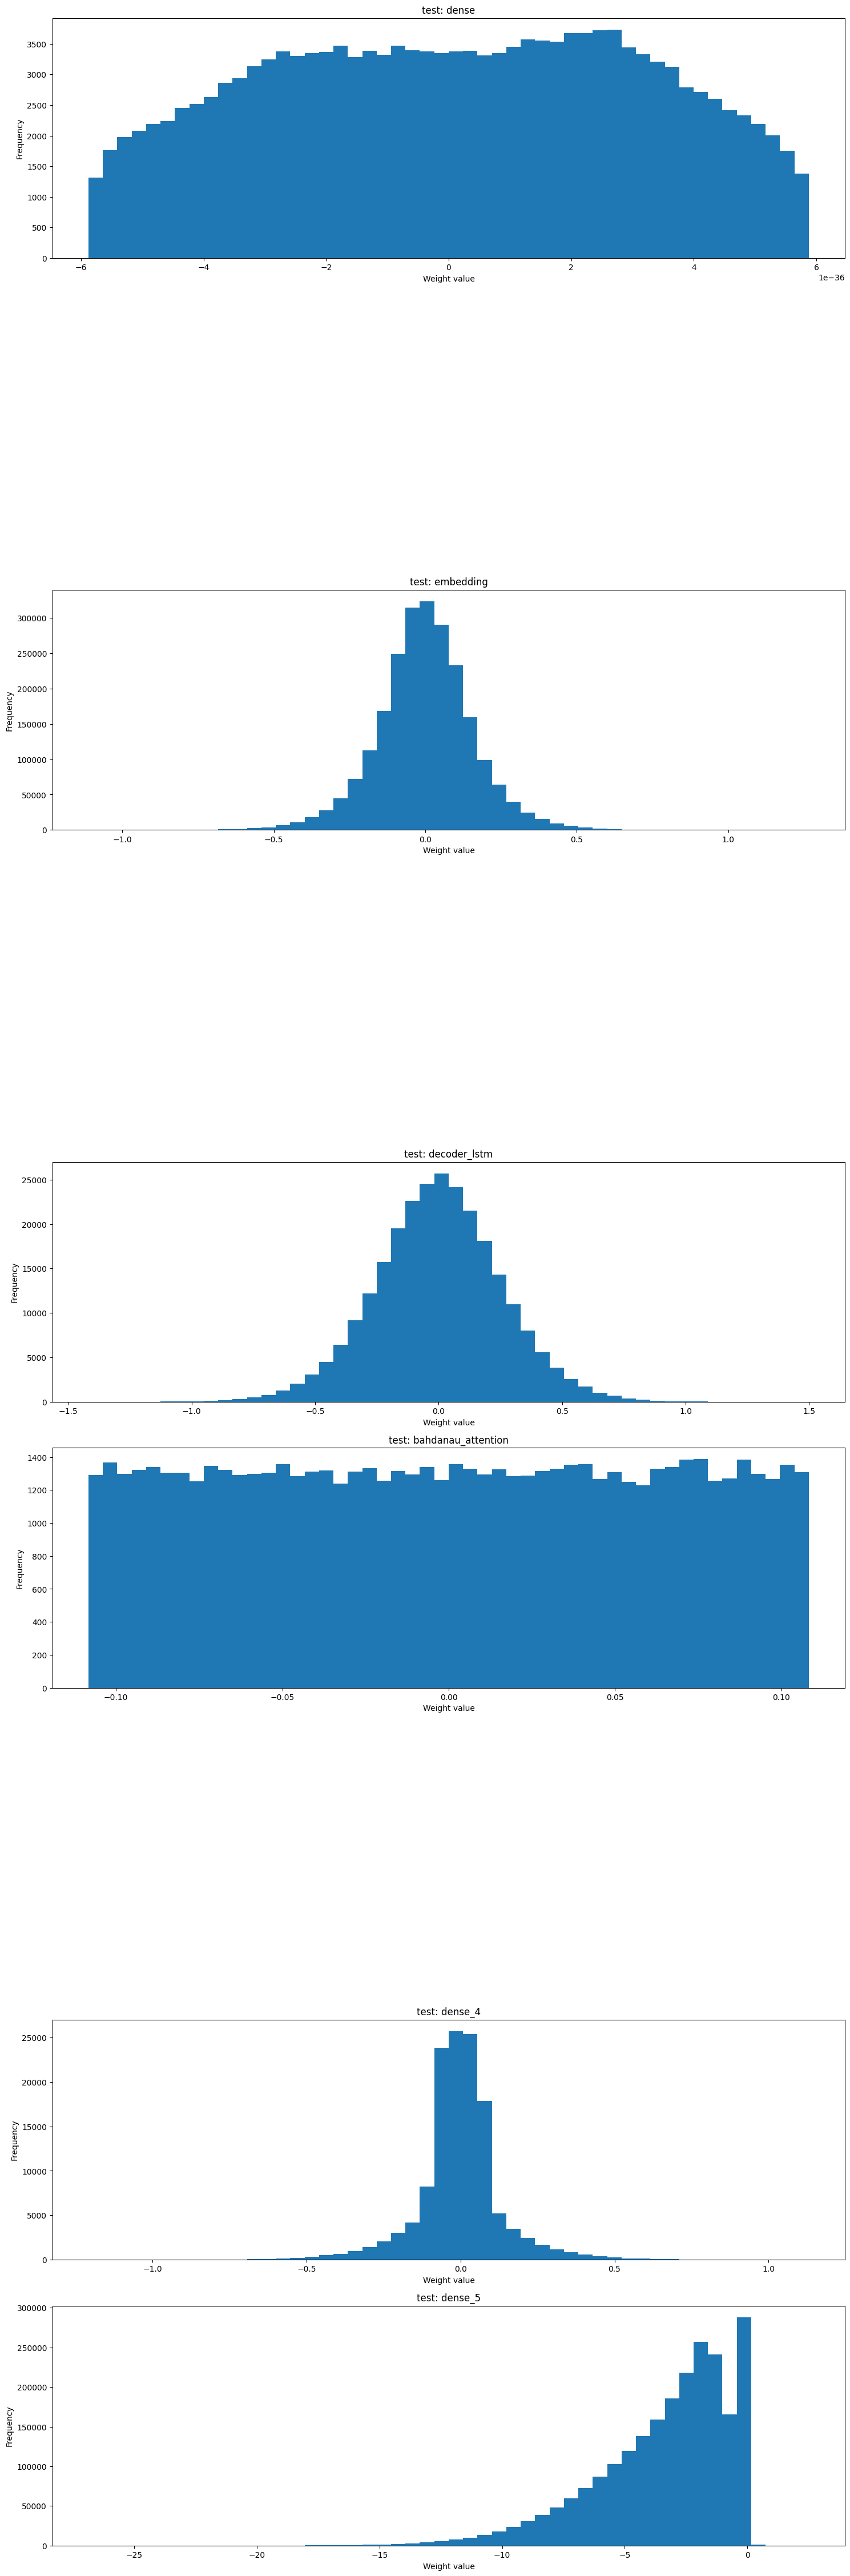

In [62]:
import matplotlib.pyplot as plt

# List of models you want to visualize
# models = [caption_model, loaded_model,loaded_model_mobt,att_model]  # Replace with your actual models
models = [test_model]  # Replace with your actual models

# model_names = ['current', 'loaded_model','loaded_model_mobt',att_model]  # Replace with your actual model names
model_names = ['test']  # Replace with your actual model names

# Find the maximum number of layers across all models
max_layers = max([len(model.layers) for model in models])

# Create a single figure for all subplots
fig = plt.figure(figsize=(15, max_layers * 5))

# Iterate through the models
for model_idx, model in enumerate(models):
    model_name = model_names[model_idx]

    # Access the layers of the current model
    layers = model.layers

    # Iterate through the layers and visualize the weights
    for layer_idx, layer in enumerate(layers):
        layer_name = layer.name
        layer_weights = layer.get_weights()

        if len(layer_weights) > 0:
            # Get the weight matrix for the layer (ignoring biases)
            weight_matrix = layer_weights[0]

            # Create a subplot for the current layer and model
            ax = fig.add_subplot(max_layers, len(models), layer_idx * len(models) + model_idx + 1)

            # Plot a histogram of the weight distribution
            ax.hist(weight_matrix.flatten(), bins=50)
            ax.set_title(f'{model_name}: {layer_name}')
            ax.set_xlabel('Weight value')
            ax.set_ylabel('Frequency')

# Display all subplots
plt.tight_layout()
plt.show()

In [63]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
for filename in glob.glob('./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/*.jpg'): #assuming jpg
    img_paths.append(filename)

    if len(img_paths)>10:
      break
print(img_paths)

['./drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000571635.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000202658.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000203564.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000410627.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000208408.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000581177.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000153184.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_train2017_000000027842.jpg', './drive/MyDrive/3조/sample_train_coco (1)/sample_train_coco/_content_coco_train2017_tr

In [64]:
print(model_e[:-2])
x= np.arange(1,577)

y = np.sin(x/10)*2
noise = y+ np.random.normal(0,0.1, size = (1,576))
print(y.shape)
print(noise.shape)

mobilenet
(576,)
(1, 576)


In [65]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")

        
        if model_e[:-2] == "vgg":
            image = image.resize((224,224))
            print("resizing")
        elif(model_e[:-2] == "mobilenet"):
            image = image.resize((224,224))
            print("resizing")          

        else:
            image = image.resize((299,299))


        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)

        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end' or word =='<end>':
            in_text = in_text[:-3]  +"<"+in_text [-3:] + ">"
            break
    return in_text




In [66]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = '<start>'

    units = decoder_lstm.decoder_units
    attention_layer  = model.layers[-4]
    attention_weights_list = []


    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        initial_state = model.layers[2](model.layers[1](photo))
        decoder_embedding = model.layers[3](sequence)

        decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=[initial_state, initial_state])

        c_v, at_wt = attention_layer(decoder_outputs, state_h)
        
        attention_weights_list.append(at_wt)

        pred = model.predict([photo, sequence], verbose=0)

        pred = np.argmax(pred, axis=-1)

        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word

        if word == 'end' or word == '<end>':
            in_text = in_text[:-3] + "<" + in_text[-3:] + ">"
            break
    attention_weights_array = np.squeeze(np.array(attention_weights_list))
    return in_text, attention_weights_array

In [67]:
test_model.layers[-4]
test_model.layers[-5].decoder_units


256

In [68]:
# 230501
# CNN_model= Xception(include_top=False, pooling="avg")
CNN_model= modified_mobilenetv3small
# CNN_model= modified_vgg16


In [69]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
img_paths = []
val_key = list(data_val.keys())
random.shuffle(val_key)
for filename in val_key:
    img_paths.append(filename)

    if len(img_paths)>10:
      break


print(img_paths)

['/content/content/custom_train_coco_30k/000000281008.jpg', '/content/content/custom_train_coco_30k/000000406366.jpg', '/content/content/custom_train_coco_30k/000000361222.jpg', '/content/content/custom_train_coco_30k/000000331793.jpg', '/content/content/custom_train_coco_30k/000000228306.jpg', '/content/content/custom_train_coco_30k/000000574271.jpg', '/content/content/custom_train_coco_30k/000000028611.jpg', '/content/content/custom_train_coco_30k/000000454565.jpg', '/content/content/custom_train_coco_30k/000000511642.jpg', '/content/content/custom_train_coco_30k/000000310092.jpg', '/content/content/custom_train_coco_30k/000000062481.jpg']


In [70]:


ii = 10

photo = extract_features(img_paths[ii], CNN_model)

dataset[img_paths[ii]]




resizing
1/1 [==============================] - 4s 4s/step


['<start> A teddy bear with a tag sitting on a large rock. <end>',
 '<start> A brown teddy bear sitting on top of rocks. <end>',
 '<start> A fuzzy teddy bear sitting on top of a boulder. <end>',
 '<start> A teddy bear sitting on some rocks.  <end>',
 '<start> A cute little brown teddy bear sits on a rock by a bush.  <end>']

In [71]:
result =  generate_desc(test_model, tokenizer,photo, max_length)
result[1].shape

(11, 26)

'<start> a man is holding a tennis racquet in her hand <end>'

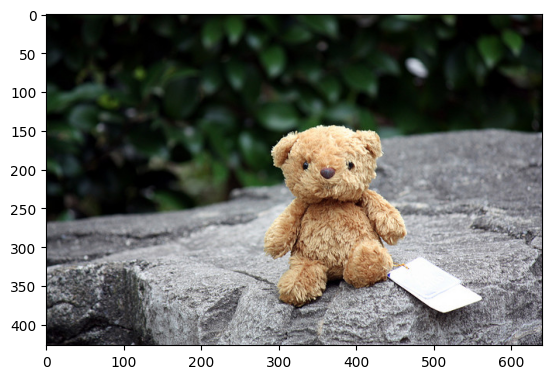

In [72]:

img = Image.open(img_paths[ii])
plt.imshow(img)

result[0]


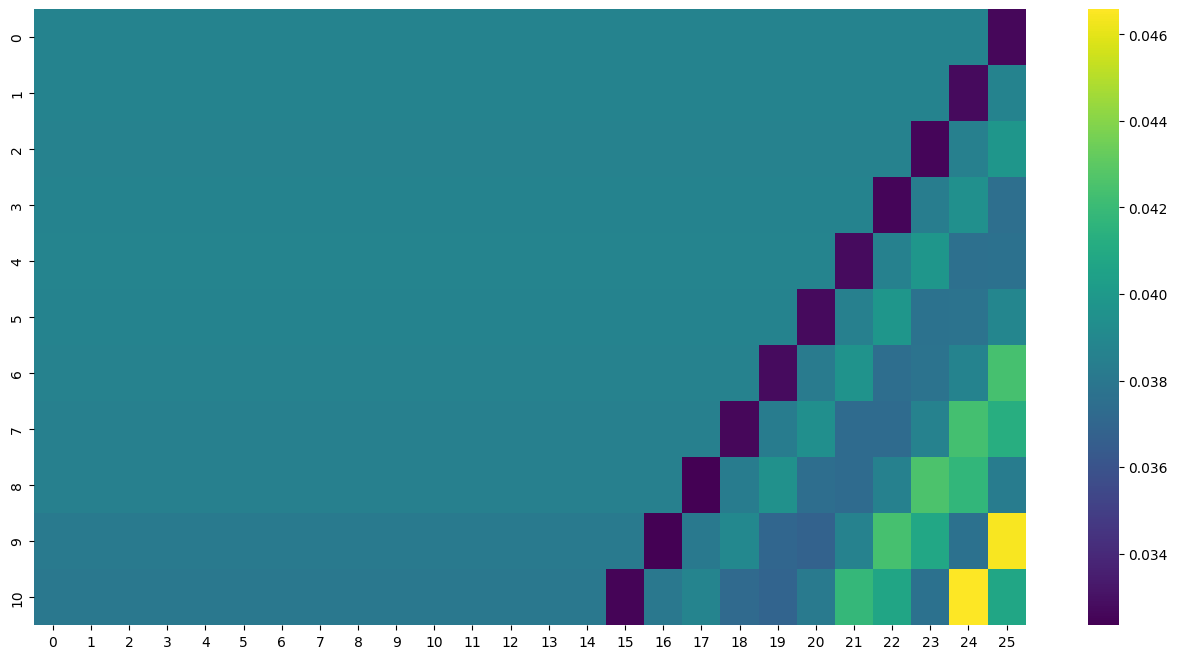

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
generated_text, attention_weights =generate_desc(test_model, tokenizer, photo, max_length)
plt.figure(figsize=(16,8))
sns.heatmap(attention_weights, cmap ='viridis',)

plt.show()

In [74]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [75]:
from tensorflow.keras.layers import GlobalAveragePooling2D


IMAGE_SHAPE=(224, 224, 3)

vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
) 
vgg16.trainable=False

x = vgg16.output
x = GlobalAveragePooling2D()(x)

modified_vgg16 = Model(inputs=vgg16.input, outputs=x)

In [76]:
print(img_paths[2], CNN_model)

/content/content/custom_train_coco_30k/000000361222.jpg <keras.engine.functional.Functional object at 0x7f703c043940>


resizing
1/1 [==============================] - 0s 27ms/step



<start> a man is holding a tennis racquet in her hand <end>


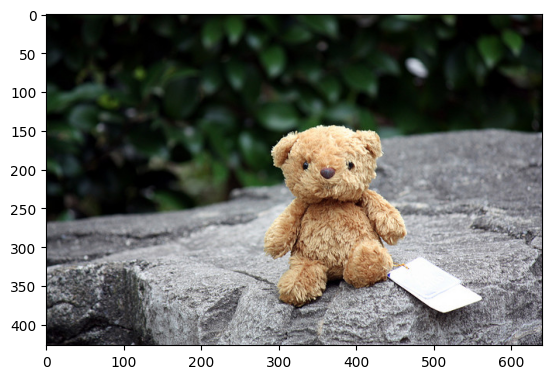

In [77]:

# caption_model = loaded_model


# ii = 5
ii = 10


photo = extract_features(img_paths[ii], CNN_model)

img = Image.open(img_paths[ii])
description = generate_desc(test_model, tokenizer, photo, max_length)[0]
print("\n\n")
print(description)
plt.imshow(img)


In [78]:
len(img_paths)

11

In [79]:
img_paths


['/content/content/custom_train_coco_30k/000000281008.jpg',
 '/content/content/custom_train_coco_30k/000000406366.jpg',
 '/content/content/custom_train_coco_30k/000000361222.jpg',
 '/content/content/custom_train_coco_30k/000000331793.jpg',
 '/content/content/custom_train_coco_30k/000000228306.jpg',
 '/content/content/custom_train_coco_30k/000000574271.jpg',
 '/content/content/custom_train_coco_30k/000000028611.jpg',
 '/content/content/custom_train_coco_30k/000000454565.jpg',
 '/content/content/custom_train_coco_30k/000000511642.jpg',
 '/content/content/custom_train_coco_30k/000000310092.jpg',
 '/content/content/custom_train_coco_30k/000000062481.jpg']

In [80]:
attention_weights.shape

(11, 26)

resizing
1/1 [==============================] - 0s 25ms/step


predict:    0 <start> a man is holding a tennis racquet in her hand <end>
answer:    <start> A herd of giraffe standing around a pile of rocks. <end>
bleu score: 0.027895820162122397
resizing
1/1 [==============================] - 0s 24ms/step


predict:    1 <start> a man is holding a tennis racquet in her hand <end>
answer:    <start> Two people on motorcycles are racing around  a track. <end>
bleu score: 0.027895820162122397
resizing
1/1 [==============================] - 0s 25ms/step


predict:    2 <start> a man is holding a tennis racquet in her hand <end>
answer:    <start> A dog sitting in a car looking at something. <end>
bleu score: 0.03087179980863256
resizing
1/1 [==============================] - 0s 24ms/step


predict:    3 <start> a man is holding a tennis racquet in her hand <end>
answer:    <start> A man flying into the air on top of a skateboard ramp. <end>
bleu score: 0.03087179980863256
resizing
1/1 [===

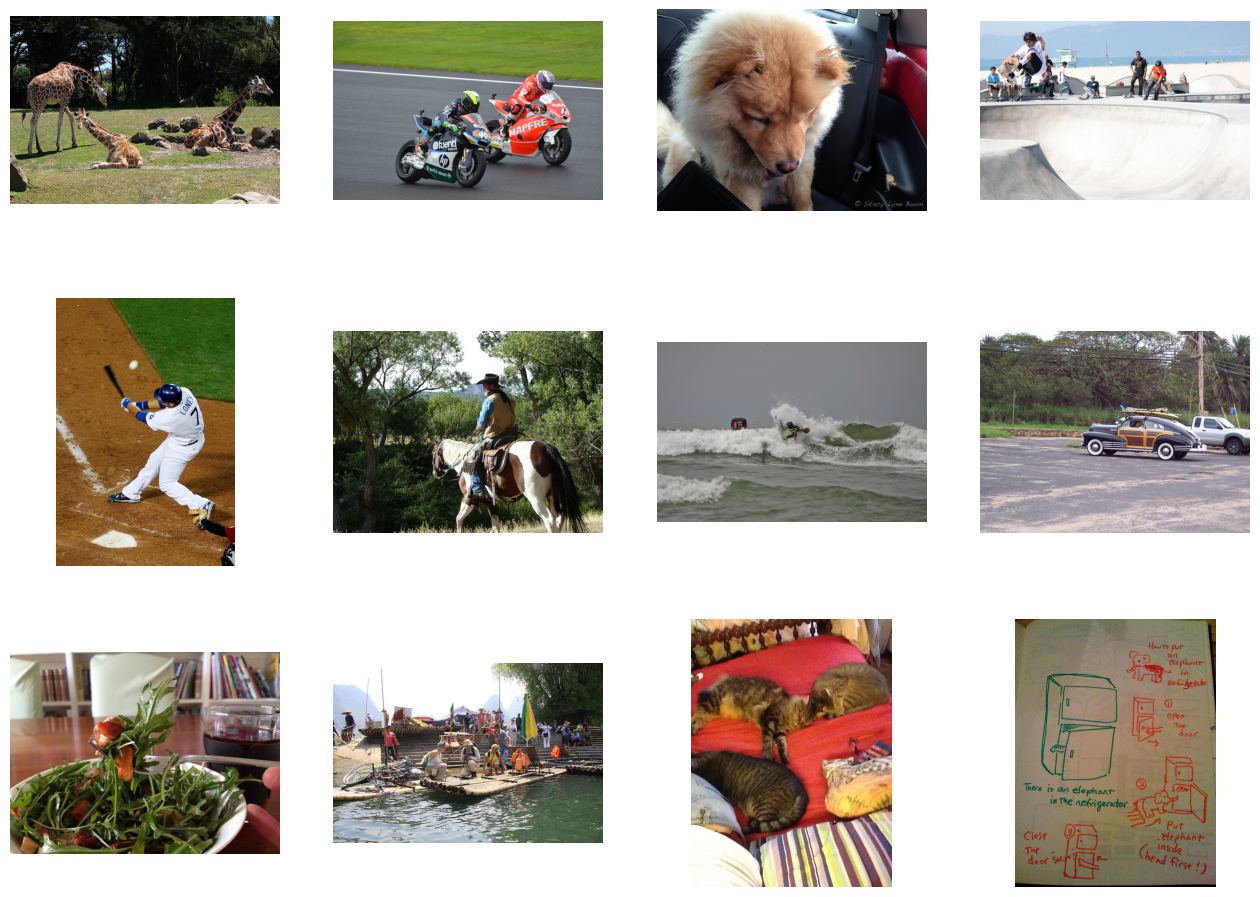

In [81]:

from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

fig = plt.gcf()
fig.set_size_inches(16, 16)

score_sum = 0


next_pix = list(dataset.keys())
random.shuffle(next_pix)

# for i, image in enumerate(img_paths):
for i, image in enumerate(next_pix[0:12]):
  
  photo = extract_features(image,CNN_model)
  img = Image.open(image)
  description = generate_desc(test_model, tokenizer, photo, max_length)[0]
  print("\n")
  sp = plt.subplot(4, 4, i + 1)
  sp.axis('Off')
  plt.imshow(img)

  print("predict:   ",i, description)
  print("answer:   ",dataset[image][0])
  reference = list(map(lambda x: x[7:-5].split(),dataset[image]))
  candidate = description[7:-5].lower().split()
  score = sentence_bleu(reference, candidate,smoothing_function=SmoothingFunction().method4)
  print("bleu score:" , score)

  score_sum +=score

average_score = score_sum/i
print("average bleu score:" , average_score)



In [82]:
tokenizer.word_index.get('end')

3

In [83]:
token_i=tokenizer.word_index.get("woman")

print("input_index:", token_i)

input_index: 23


In [84]:
  print(list(tokenizer.word_index.keys())[:200])


['<oov>', 'a', 'end', 'start', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man', 'to', 'sitting', 'an', 'two', 'standing', 'at', 'people', 'are', 'next', 'white', 'woman', 'street', 'table', 'that', 'holding', 'large', 'person', 'some', 'it', 'down', 'top', 'group', 'up', 'field', 'small', 'near', 'black', 'tennis', 'his', 'front', 'train', 'riding', 'dog', 'plate', 'red', 'young', 'cat', 'room', 'by', 'water', 'baseball', 'sign', 'has', 'bathroom', 'playing', 'walking', 'while', 'blue', 'kitchen', 'bus', 'there', 'food', 'building', 'parked', 'pizza', 'side', 'grass', 'snow', 'green', 'bed', 'other', 'ball', 'looking', 'beach', 'three', 'for', 'boy', 'clock', 'couple', 'toilet', 'men', 'city', 'flying', 'her', 'road', 'skateboard', 'player', 'wearing', 'over', 'game', 'out', 'laying', 'sits', 'bench', 'from', 'girl', 'picture', 'wooden', 'bear', 'several', 'eating', 'brown', 'area', 'board', 'yellow', 'their', 'through', 'laptop', 'around', 'cake', 'horse', 'frisbee', 'one', 'sink'

Image size:  (640, 507, 3)
hog_image
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         11.15494728 11.43258572 ...  0.          0.
   0.        ]
 [ 0.         11.43258572 11.15494728 ...  0.          0.
   0.        ]
 ...
 [ 0.         40.5867703  41.88853455 ...  0.          0.
   0.        ]
 [ 0.         41.88853455 40.5867703  ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


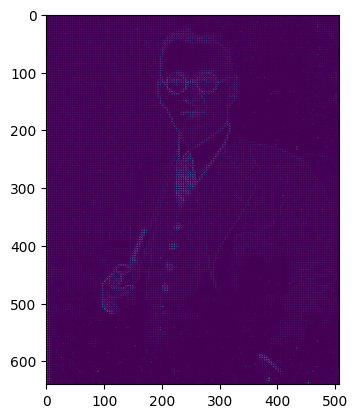

In [85]:
from skimage.feature import hog

def hog_images(crop):    
    image=crop[:,:,1]    
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True)    
    return hog_image

# img_paths = ["../input/cocods/val2017/val2017/000000035682.jpg"]
img_paths
im = cv2.imread(img_paths[2])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

normalized hog_matrix
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.28622165 0.62688943 ... 0.11268072 0.12185588 0.        ]
 [0.         0.62688943 0.28622165 ... 0.12185588 0.11268072 0.        ]
 ...
 [0.         0.06292454 0.22219767 ... 0.04330873 0.11014189 0.        ]
 [0.         0.22219767 0.06292454 ... 0.11014189 0.04330873 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


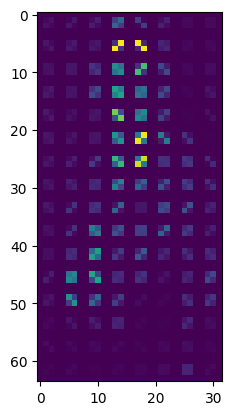

In [86]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()


In [87]:
our_CNN_feature = extract_features(img_paths[2], CNN_model)
scaler.fit(our_CNN_feature)
scaler.transform(our_CNN_feature)
print ('our_CNN_feature',our_CNN_feature)

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(our_CNN_feature, hog_vec)/(norm(our_CNN_feature)*norm(hog_vec))
print ("cos_sim",cos_sim)

resizing
1/1 [==============================] - 0s 24ms/step
our_CNN_feature [[-0.00000000e+00 -0.00000000e+00 -1.61044434e-01 -3.92958224e-02
   3.12279963e+00 -7.32900873e-02 -8.94385012e-05 -1.69018924e-01
  -6.43576533e-02 -0.00000000e+00 -1.67708576e-01 -2.82508191e-02
  -1.40806675e-01 -2.46401995e-01 -0.00000000e+00 -6.12304662e-04
  -7.15898722e-02 -1.45513251e-01 -1.73996352e-02 -3.90604627e-03
  -3.08640059e-02 -1.18827246e-01 -1.37940556e-01 -1.59059703e-01
  -2.63736881e-02 -1.49942279e-01 -0.00000000e+00 -1.66971385e-01
  -9.80966724e-03  3.13999504e-01 -1.05034500e-01 -1.80504415e-02
  -8.81940033e-03 -7.74544626e-02 -3.43161710e-02 -2.31881719e-03
  -0.00000000e+00 -1.95299298e-01 -9.15354714e-02  3.38390738e-01
  -2.93178827e-01 -0.00000000e+00 -0.00000000e+00 -8.32272246e-02
  -1.97762791e-02 -3.08451116e-01 -1.31751493e-01 -1.46802127e-01
  -1.09889135e-02 -2.08440144e-02 -0.00000000e+00 -0.00000000e+00
   3.73872787e-01 -4.95399274e-02 -1.15550064e-01 -0.00000000e+00

ValueError: ignored

In [ ]:
im2_path = next_pix[0]

im2 = cv2.imread(im2_path)
print ('original size',im2.shape)
img2 = Image.open(im2_path)
plt.imshow(img2)

In [ ]:
# im2 =  cv2.resize(im2,(32,16))
# hog_image2 = hog_images(im2)
# plt.imshow(hog_image2)

# hog_image2 = np.array(hog_image2)
# scaler.fit(hog_image2)
# scaler.transform(hog_image2)
# hog_vec2 = hog_image2.flatten()


# our_CNN_feature = extract_features(im2_path, CNN_model)
# scaler.fit(our_CNN_feature)
# scaler.transform(our_CNN_feature)

# cos_sim2 = dot(our_CNN_feature, hog_vec2)/(norm(our_CNN_feature)*norm(hog_vec2))
# print ("cos_sim2",cos_sim2)

In [ ]:
# img_paths # 
im = cv2.imread(next_pix[0])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()

print ('hog_vec\n',hog_vec)